# COVID19-related literature SQL database

In this notebook, we create a relational database dump of a set of COVID19-related publication datasets. These include:

* CORD19: https://pages.semanticscholar.org/coronavirus-research
* Dimensions: https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255

In [1]:
# magics, warnings and imports

%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, math, re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import Integer,String,Boolean,DateTime

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

#### Load datasets

In [3]:
# point here to the versions of the datasets you want to use
dimensions_filename = "datasets_input/Dimensions_01_07_2020.csv"
cord19_folder = "datasets_input/CORD19_01_07_2020"

df_dimensions = pd.read_csv(dimensions_filename, dtype=str, sep=";")
df_cord = pd.read_csv(os.path.join(cord19_folder,"metadata.csv"), dtype=str)

In [5]:
df_cord.shape

(169821, 19)

In [4]:
df_dimensions.shape

(61563, 31)

### Prepare dataframes for ingestion

#### Clean-up data frames

##### Dimensions

In [6]:
df_dimensions.head()

,Date added,Publication ID,DOI,PMID,PMCID,Title,Abstract,Source title,Source UID,Publisher,...,Research Organizations - standardized,GRID IDs,City of Research organization,Country of Research organization,Funder,UIDs of supporting grants,Times cited,Altmetric,Source Linkout,Dimensions URL
0,2020-06-24,pub.1128710293,10.4267/2042/70788,NaN,NaN,L’association hydroxychloroquine-azythromycine...,NaN,Bulletin de l Académie vétérinaire de France,jour.1082072,INIST-CNRS,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,http://documents.irevues.inist.fr/bitstream/20...,https://app.dimensions.ai/details/publication/...
1,2020-06-24,pub.1128679859,10.1038/s41590-020-0729-y,NaN,NaN,Nature Immunology turns 20,"Twenty years ago, a new immunology journal was...",Nature Immunology,jour.1022778,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,https://www.nature.com/articles/s41590-020-072...,https://app.dimensions.ai/details/publication/...
2,2020-06-24,pub.1128683930,10.1002/alr.22646,32573106,NaN,Management of chronic rhinosinusitis with ster...,"BACKGROUND: High-dose, high-volume steroid nas...",International Forum of Allergy & Rhinology,jour.1044553,NaN,...,Temple University; University of Minnesota; Un...,grid.264727.2; grid.17635.36; grid.25879.31,Philadelphia; Minneapolis; Philadelphia,United States; United States; United States,NaN,NaN,0,1,NaN,https://app.dimensions.ai/details/publication/...
3,2020-06-24,pub.1128676970,10.1111/ejh.13475,NaN,NaN,COVID‐19 complicated by parainfluenza co‐infec...,The number of people suffering from the new co...,European Journal Of Haematology,jour.1018712,NaN,...,University Hospital Cologne,grid.411097.a,Cologne,Germany,NaN,NaN,0,2,NaN,https://app.dimensions.ai/details/publication/...
4,2020-06-24,pub.1128677370,10.1002/jcp.29870,32572955,NaN,"Expression of NF‐κB, IL‐6, and IL‐10 genes, bo...",Nonalcoholic fatty liver disease (NAFLD) is on...,Journal of Cellular Physiology,jour.1005966,NaN,...,Tabriz University of Medical Sciences,grid.412888.f,Tabriz,Iran,Iran National Science Foundation,NaN,0,1,NaN,https://app.dimensions.ai/details/publication/...


In [7]:
df_dimensions.columns

Index(['Date added', 'Publication ID', 'DOI', 'PMID', 'PMCID', 'Title',
       'Abstract', 'Source title', 'Source UID', 'Publisher', 'MeSH terms',
       'Publication Date', 'PubYear', 'Volume', 'Issue', 'Pagination',
       'Open Access', 'Publication Type', 'Authors', 'Corresponding Authors',
       'Authors Affiliations', 'Research Organizations - standardized',
       'GRID IDs', 'City of Research organization',
       'Country of Research organization', 'Funder',
       'UIDs of supporting grants', 'Times cited', 'Altmetric',
       'Source Linkout', 'Dimensions URL'],
      dtype='object')

In [8]:
df_dimensions.drop(columns=['Date added', 'Publisher', 'Authors', 'Corresponding Authors',
       'Authors Affiliations', 'Research Organizations - standardized',
       'GRID IDs', 'City of Research organization',
       'Country of Research organization', 'Funder',
       'UIDs of supporting grants', 'Times cited', 'Altmetric',
       'Source Linkout'], inplace=True)

In [9]:
df_dimensions.columns

Index(['Publication ID', 'DOI', 'PMID', 'PMCID', 'Title', 'Abstract',
       'Source title', 'Source UID', 'MeSH terms', 'Publication Date',
       'PubYear', 'Volume', 'Issue', 'Pagination', 'Open Access',
       'Publication Type', 'Dimensions URL'],
      dtype='object')

In [10]:
df_dimensions.rename(columns={'Publication ID':'dimensions_id', 'DOI':'doi', 'PMID':'pmid', 'PMCID':'pmcid', 'Title':'title', 'Abstract':'abstract',
       'Source title':'journal', 'Source UID':'source_uid', 'MeSH terms':'mesh_terms', 'Publication Date':'publication_date',
       'PubYear':'publication_year', 'Volume':'volume', 'Issue':'issue', 'Pagination':'pages', 'Open Access':'open_access',
       'Publication Type':'publication_type', 'Dimensions URL':'dimensions_url'}, inplace=True)

In [11]:
df_dimensions[pd.isnull(df_dimensions.abstract)].shape

(23749, 17)

In [12]:
def get_year(date):
    if isinstance(date,str) and len(date)>3 and date[:4].isdigit():
        return date[:4]
    return ""

month_to_number = {"Jan":"1","Feb":"2","Mar":"3","Apr":"4","May":"5","Jun":"6","Jul":"7","Aug":"8","Sep":"9","Oct":"10","Nov":"11","Dec":"12"}

def get_month(date):
    if isinstance(date,str) and len(date)>6:
        if "-" in date and date.split("-")[1].isdigit():
            return str(int(date.split("-")[1]))
        else:
            try:
                return month_to_number[date.split()[1]]
            except:
                return ""
    return ""

def sanitize_string(s):
    return " ".join(s.split())

In [13]:
df_dimensions["publication_year"] = df_dimensions["publication_year"].apply(get_year)
df_dimensions["publication_month"] = df_dimensions["publication_date"].apply(get_month)
df_dimensions["arxiv_id"] = ""

In [14]:
df_dimensions.drop(columns="publication_date", inplace=True)
df_dimensions = df_dimensions.fillna('')

Retrieve arXiv ID for Dimensions papers

In [15]:
# Sync option, quite slow

"""
import requests, re

for index, row in df_dimensions[df_dimensions.journal=="arXiv"].iterrows():
    r = requests.get(row["dimensions_url"])
    if r.status_code == 200:
        arxiv_url = re.search("https://arxiv.org/pdf/arXiv:[0-9]+.[0-9]+",r.text).group()
        arxiv_id = arxiv_url.split(":")[-1]
        row["arxiv_id"] = arxiv_id
"""

'\nimport requests, re\n\nfor index, row in df_dimensions[df_dimensions.journal=="arXiv"].iterrows():\n    r = requests.get(row["dimensions_url"])\n    if r.status_code == 200:\n        arxiv_url = re.search("https://arxiv.org/pdf/arXiv:[0-9]+.[0-9]+",r.text).group()\n        arxiv_id = arxiv_url.split(":")[-1]\n        row["arxiv_id"] = arxiv_id\n'

In [16]:
# from https://towardsdatascience.com/fast-and-async-in-python-accelerate-your-requests-using-asyncio-62dafca83c33
# aSync option, fast

import aiohttp
import requests
import asyncio

from aiohttp import ClientSession

def extract_fields_from_response(response):
    """Extract arxiv id from API's response"""
    search_res = re.search("arXiv:[0-9]+.[0-9]+",response)
    if search_res:
        arxiv_url = search_res.group()
        arxiv_id = arxiv_url.split(":")[-1]
        return arxiv_id
    return ""

async def get_details_async(session, payload):   
    response = await session.request(method='GET', url=payload[1]["dimensions_url"])
    if response.status != 200:
        print(payload[0], response.status)
        pass
    return await response.text()

async def run_program(session, payload):
    """Wrapper for running program in an asynchronous manner"""
    response = await get_details_async(session, payload)
    arxiv_id = extract_fields_from_response(response)
    return (arxiv_id,payload[1]["dimensions_url"])

payloads = df_dimensions[df_dimensions.journal=="arXiv"]
connector = aiohttp.TCPConnector(limit=5)
async with aiohttp.ClientSession(connector=connector) as session:
    results = await asyncio.gather(*[run_program(session, payload) for payload in payloads.iterrows()])

In [17]:
df_tmp = pd.DataFrame.from_dict({"arxiv_id":[x[0] for x in results],"dimensions_url":[x[1] for x in results]})

In [18]:
df_tmp.shape

(1349, 2)

In [19]:
df_dimensions = df_dimensions.merge(df_tmp, how="left", left_on="dimensions_url", right_on="dimensions_url")
df_dimensions.drop(columns="arxiv_id_x", inplace=True)
df_dimensions.rename(columns={"arxiv_id_y":"arxiv_id"}, inplace=True)
df_dimensions = df_dimensions.fillna('')

In [20]:
df_dimensions.shape

(61563, 18)

In [21]:
df_dimensions[df_dimensions.journal=="arXiv"].shape

(1349, 18)

In [22]:
df_dimensions.head()

,dimensions_id,doi,pmid,pmcid,title,abstract,journal,source_uid,mesh_terms,publication_year,volume,issue,pages,open_access,publication_type,dimensions_url,publication_month,arxiv_id
0,pub.1128710293,10.4267/2042/70788,,,L’association hydroxychloroquine-azythromycine...,,Bulletin de l Académie vétérinaire de France,jour.1082072,,2020,,2,,All OA; Hybrid,article,https://app.dimensions.ai/details/publication/...,1,
1,pub.1128679859,10.1038/s41590-020-0729-y,,,Nature Immunology turns 20,"Twenty years ago, a new immunology journal was...",Nature Immunology,jour.1022778,,2020,21,7,697-697,All OA; Bronze,article,https://app.dimensions.ai/details/publication/...,7,
2,pub.1128683930,10.1002/alr.22646,32573106,,Management of chronic rhinosinusitis with ster...,"BACKGROUND: High-dose, high-volume steroid nas...",International Forum of Allergy & Rhinology,jour.1044553,,2020,,,,Closed,article,https://app.dimensions.ai/details/publication/...,6,
3,pub.1128676970,10.1111/ejh.13475,,,COVID‐19 complicated by parainfluenza co‐infec...,The number of people suffering from the new co...,European Journal Of Haematology,jour.1018712,,2020,,,,Closed,article,https://app.dimensions.ai/details/publication/...,6,
4,pub.1128677370,10.1002/jcp.29870,32572955,,"Expression of NF‐κB, IL‐6, and IL‐10 genes, bo...",Nonalcoholic fatty liver disease (NAFLD) is on...,Journal of Cellular Physiology,jour.1005966,,2020,,,,Closed,article,https://app.dimensions.ai/details/publication/...,6,


In [23]:
df_dimensions[df_dimensions.doi==""].shape

(1890, 18)

##### CORD19

In [24]:
df_cord.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [25]:
df_cord["license"].value_counts()

unk            81125
no-cc          44301
cc-by          15105
els-covid      14973
medrxiv         4703
cc-by-nc        2097
arxiv           2072
cc-by-nc-nd     1464
biorxiv         1399
green-oa         876
cc-by-nc-sa      635
bronze-oa        580
cc0              282
hybrid-oa        134
gold-oa           40
cc-by-nd          33
cc-by-sa           2
Name: license, dtype: int64

In [26]:
df_cord["source_x"].value_counts()

Medline                               49413
WHO                                   30923
Medline; PMC                          26653
PMC                                   26563
Elsevier; Medline; PMC                19370
MedRxiv                                4397
Elsevier; PMC                          2971
ArXiv                                  2044
Elsevier; PMC; WHO                     1590
Medline; PMC; WHO                      1407
BioRxiv                                1158
PMC; WHO                               1084
Medline; WHO                            661
Elsevier; Medline; PMC; WHO             409
BioRxiv; MedRxiv                        321
Elsevier                                255
MedRxiv; Medline; PMC                   176
MedRxiv; Medline                        131
BioRxiv; Medline; PMC                    69
BioRxiv; Medline                         60
ArXiv; Medline; PMC                      31
BioRxiv; Medline; PMC; WHO               24
ArXiv; Elsevier; Medline; PMC   

In [27]:
# how many full text files
df_cord[(pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files))].shape

(77777, 19)

In [28]:
df_cord[(pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files))].shape[0]/df_cord.shape[0]

0.4579940054528003

In [29]:
# check Medline
df_cord[(df_cord.source_x=="Medline")&((pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files)))].shape[0]/df_cord[(df_cord.source_x=="Medline")].shape[0]

0.0

In [30]:
df_cord[(df_cord.source_x=="Medline")].shape[0]

49413

In [31]:
# check NOT Medline
df_cord[(df_cord.source_x!="Medline")&((pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files)))].shape[0]/df_cord[(df_cord.source_x!="Medline")].shape[0]

0.6459454521294267

In [32]:
df_cord[(df_cord.source_x!="Medline")].shape[0]

120408

In [33]:
# NEW columns (for now, we drop)
df_cord.drop(columns=["cord_uid","url","pdf_json_files","pmc_json_files","s2_id"],inplace=True)

In [34]:
df_cord.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id'],
      dtype='object')

In [35]:
df_cord.drop(columns='authors', inplace=True)
df_cord = df_cord.fillna('')

In [36]:
df_cord.rename(columns={'source_x':'source', 'pubmed_id': 'pmid',
       'mag_id': 'ms_academic_id', 'who_covidence_id': 'who_covidence'}, inplace=True)

In [37]:
df_cord["publication_year"] = df_cord["publish_time"].apply(get_year)
df_cord["publication_month"] = df_cord["publish_time"].apply(get_month)

In [38]:
df_cord.drop(columns='publish_time', inplace=True)

In [39]:
df_cord['pages'] = ""
df_cord['volume'] = ""
df_cord['issue'] = ""
df_cord["dimensions_id"] = ""

In [40]:
df_cord.head()

,sha,source,title,doi,pmcid,pmid,license,abstract,journal,ms_academic_id,who_covidence,arxiv_id,publication_year,publication_month,pages,volume,issue,dimensions_id
0,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,BMC Infect Dis,,,,2001,7,,,,
1,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,Respir Res,,,,2000,8,,,,
2,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,Respir Res,,,,2000,8,,,,
3,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,Respir Res,,,,2001,2,,,,
4,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,Respir Res,,,,2001,5,,,,


In [41]:
df_cord[(df_cord.doi=="") & ((df_cord.sha!="") | (df_cord.pmid!="") | (df_cord.pmcid!="") | df_cord.arxiv_id!="")].shape

(42268, 18)

In [42]:
df_cord[(df_cord.doi=="") & (df_cord.pmid=="") & (df_cord.pmcid=="")].shape

(30947, 18)

In [43]:
df_cord[((df_cord.doi=="") & (df_cord.pmid=="") & (df_cord.pmcid==""))&(df_cord.arxiv_id!="")].shape

(1953, 18)

In [44]:
df_dimensions.shape

(61563, 18)

In [45]:
df_cord.shape

(169821, 18)

In [46]:
df_dimensions[((df_dimensions.doi=="") & (df_dimensions.pmid=="") & (df_dimensions.pmcid==""))&(df_dimensions.journal=="arXiv")].shape

(1336, 18)

In [47]:
df_dimensions[df_dimensions.journal=="arXiv"].shape

(1349, 18)

In [48]:
df_cord[df_cord.arxiv_id!=""].shape

(2138, 18)

In [49]:
df_cord[df_cord.title=="CORD-19: The Covid-19 Open Research Dataset"]

,sha,source,title,doi,pmcid,pmid,license,abstract,journal,ms_academic_id,who_covidence,arxiv_id,publication_year,publication_month,pages,volume,issue,dimensions_id
92679,bc411487f305e451d7485e53202ec241fcc97d3b,ArXiv,CORD-19: The Covid-19 Open Research Dataset,,,,arxiv,The Covid-19 Open Research Dataset (CORD-19) i...,,,,2004.10706,2020,4,,,,


In [50]:
df_dimensions[df_dimensions.title=="CORD-19: The Covid-19 Open Research Dataset"]

,dimensions_id,doi,pmid,pmcid,title,abstract,journal,source_uid,mesh_terms,publication_year,volume,issue,pages,open_access,publication_type,dimensions_url,publication_month,arxiv_id
42642,pub.1126924428,,,,CORD-19: The Covid-19 Open Research Dataset,The Covid-19 Open Research Dataset (CORD-19) i...,arXiv,jour.1371339,,2020,,,,"All OA; Green, Submitted",preprint,https://app.dimensions.ai/details/publication/...,4,2004.10706


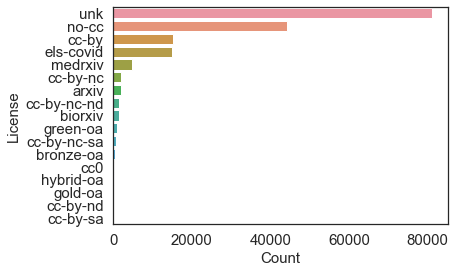

In [51]:
# license
df_sub = df_cord[df_cord.license.isin(df_cord.license.value_counts()[:30].index.tolist())]
b = sns.countplot(y="license", data=df_sub, order=df_sub['license'].value_counts().index)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Count",fontsize=15)
b.set_ylabel("License",fontsize=15)
b.tick_params(labelsize=15)

### Prepare tables

In [52]:
# the main table: pub

In [53]:
pub_table_columns = ['title','abstract','publication_year','publication_month','journal','volume','issue','pages','doi','pmid','pmcid','dimensions_id','arxiv_id']

df_pub = df_dimensions[pub_table_columns].append(df_cord[pub_table_columns], ignore_index=True)

In [54]:
df_pub["title"] = df_pub["title"].apply(sanitize_string)
df_pub["abstract"] = df_pub["abstract"].apply(sanitize_string)
df_pub["doi"] = df_pub["doi"].apply(str.lower)
df_pub["pmid"] = df_pub["pmid"].apply(str.lower)
df_pub["pmcid"] = df_pub["pmcid"].apply(str.lower)
df_pub["dimensions_id"] = df_pub["dimensions_id"].apply(str.lower)
df_pub["arxiv_id"] = df_pub["arxiv_id"].apply(str.lower)

In [55]:
df_pub.shape

(231384, 13)

In [56]:
df_pub[(df_pub.doi=="") & (df_pub.pmid=="") & (df_pub.pmcid=="") & (df_pub.dimensions_id=="") & (df_pub.arxiv_id=="")].shape

(28994, 13)

In [57]:
# check to have at least one valid identifier per publication
# we drop publications which do not: hopefully, they will be equipped with an identifier in future releases

df_pub = df_pub[~((df_pub.doi=="") & (df_pub.pmid=="") & (df_pub.pmcid=="") & (df_pub.dimensions_id=="") & (df_pub.arxiv_id==""))]

In [58]:
df_pub[df_pub.doi=="0.1126/science.abb7331"]

,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,arxiv_id


In [59]:
# drop duplicates, first on dois then pmids then pmcids. We need this to keep empty values!
df_tmp = df_pub[df_pub.doi==""]
df_pub1 = df_pub[df_pub.doi!=""].groupby('doi').first()
df_pub1.reset_index(inplace=True)
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_pub2 = df_tmp[df_tmp.pmid!=""].groupby('pmid').first()
df_pub2.reset_index(inplace=True)
df_tmp3 = df_tmp2[df_tmp2.pmcid==""]
df_pub3 = df_tmp2[df_tmp2.pmcid!=""].groupby('pmcid').first()
df_pub3.reset_index(inplace=True)
df_tmp4 = df_tmp3[df_tmp3.arxiv_id==""]
df_pub4 = df_tmp3[df_tmp3.arxiv_id!=""].groupby('arxiv_id').first()
df_pub4.reset_index(inplace=True)
df_pub5 = df_tmp4[df_tmp4.dimensions_id!=""].groupby('dimensions_id').first()
df_pub5.reset_index(inplace=True)

In [60]:
df_pub1[df_pub1.doi=="0.1126/science.abb7331"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id


In [61]:
df_pub = pd.concat([df_pub1,df_pub2,df_pub3,df_pub4,df_pub5])

In [62]:
# add PK and reset index
df_pub.reset_index(drop=True,inplace=True)
df_pub["pub_id"] = df_pub.index.values

In [63]:
df_pub.shape

(160656, 14)

In [64]:
df_pub[df_pub.arxiv_id=="2003.08720"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id
140612,10.3934/mine.2021013,A simple SIR model with a large set of asympto...,There is increasing evidence that one of the m...,2020,3,,,,,,,,2003.08720,140612
158867,,Predicting the evolution of the COVID-19 epide...,The presence of a large number of infected ind...,2020,5,arXiv,,,,,,pub.1127904057,2003.08720,158867


In [68]:
# create other tables via joins

df_datasource = pd.DataFrame.from_dict({"source":["CORD19","Dimensions"],"url":["https://pages.semanticscholar.org/coronavirus-research","https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255"]})
df_cord_metadata = df_cord[['source','license','ms_academic_id','who_covidence','doi','pmid','pmcid','sha','arxiv_id']]
df_dimensions_metadata = df_dimensions[['dimensions_id', 'doi', 'pmid', 'pmcid','arxiv_id', 'source_uid', 'mesh_terms',
       'open_access', 'publication_type', 'dimensions_url']]

In [69]:
df_cord_metadata["doi"] = df_cord_metadata["doi"].apply(str.lower)
df_cord_metadata["pmid"] = df_cord_metadata["pmid"].apply(str.lower)
df_cord_metadata["pmcid"] = df_cord_metadata["pmcid"].apply(str.lower)
df_dimensions_metadata["doi"] = df_dimensions_metadata["doi"].apply(str.lower)
df_dimensions_metadata["pmid"] = df_dimensions_metadata["pmid"].apply(str.lower)
df_dimensions_metadata["pmcid"] = df_dimensions_metadata["pmcid"].apply(str.lower)

In [70]:
df_datasource.head()

,source,url
0,CORD19,https://pages.semanticscholar.org/coronavirus-...
1,Dimensions,https://docs.google.com/spreadsheets/d/1-kTZJZ...


In [71]:
# CORD19 metadata

In [72]:
df_cord_metadata.shape

(169821, 9)

In [73]:
df_pub[df_pub.doi=="0.1126/science.abb7331"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id


In [74]:
#We need this to keep empty values!

df_tmp = df_cord_metadata[df_cord_metadata.doi==""]
df_cord_metadata1 = pd.merge(df_cord_metadata[df_cord_metadata.doi!=""], df_pub[['pub_id','doi']],  how='inner', left_on=['doi'], right_on=['doi'])
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_cord_metadata2 = pd.merge(df_tmp[df_tmp.pmid!=""], df_pub[['pub_id','pmid']],  how='inner', left_on=['pmid'], right_on=['pmid'])
df_tmp3 = df_tmp2[df_tmp2.pmcid==""]
df_cord_metadata3 = pd.merge(df_tmp2[df_tmp2.pmcid!=""], df_pub[['pub_id','pmcid']],  how='inner', left_on=['pmcid'], right_on=['pmcid'])
df_cord_metadata4 = pd.merge(df_tmp3[df_tmp3.arxiv_id!=""], df_pub[['pub_id','arxiv_id']],  how='inner', left_on=['arxiv_id'], right_on=['arxiv_id'])

In [75]:
df_cord_metadata1 = df_cord_metadata1.groupby("doi").first()
df_cord_metadata1.reset_index(inplace=True)
df_cord_metadata2 = df_cord_metadata2.groupby("pmid").first()
df_cord_metadata2.reset_index(inplace=True)
df_cord_metadata3 = df_cord_metadata3.groupby("pmcid").first()
df_cord_metadata3.reset_index(inplace=True)
df_cord_metadata4 = df_cord_metadata4.groupby("arxiv_id").first()
df_cord_metadata4.reset_index(inplace=True)

In [76]:
df_cord_metadata = pd.concat([df_cord_metadata1,df_cord_metadata2,df_cord_metadata3,df_cord_metadata4])

In [77]:
df_cord_metadata.shape

(140351, 10)

In [78]:
# read full texts in
folders = ['document_parses/pdf_json']
shas = list()
full_texts = list()

for folder in folders:
    for root, dirs, files in os.walk(os.path.join(cord19_folder,folder)):
        for file in tqdm(files):
            if ".json" in file: # read
                data = json.loads(codecs.open(os.path.join(root,file)).read())
                sha = data["paper_id"]
                full_text = " ".join(sanitize_string(section["text"]) for section in data["body_text"])
                shas.append(sha)
                full_texts.append(full_text)

In [79]:
df_cord_fulltext = pd.DataFrame.from_dict({"sha":shas,"full_text":full_texts})

In [80]:
df_cord_fulltext.shape

(78741, 2)

In [81]:
df_cord_metadata = pd.merge(df_cord_metadata, df_cord_fulltext,  how='left', left_on=['sha'], right_on=['sha'])
df_cord_metadata = df_cord_metadata.fillna('')
df_cord_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [82]:
df_cord_metadata.head()

,doi,source,license,ms_academic_id,who_covidence,pmid,pmcid,sha,arxiv_id,pub_id,full_text
0,10.0376/cma.j.issn.0376-2491.2020.0002,Medline; WHO,unk,,#615,32036640,,,,1,
1,10.1001/amajethics.2020.344,Medline,unk,,,32345430,,,,2,
2,10.1001/amajethics.2020.441,Medline,unk,,,32449663,,,,3,
3,10.1001/amajethics.2020.55,Medline,unk,,,31958392,,,,4,
4,10.1001/archdermatol.2010.96,Medline,unk,,,20566928,,,,5,


In [83]:
df_cord_metadata[df_cord_metadata.arxiv_id!=""].head()

,doi,source,license,ms_academic_id,who_covidence,pmid,pmcid,sha,arxiv_id,pub_id,full_text
3260,10.1002/jmv.25885,ArXiv; Medline; PMC,no-cc,,,32329522,pmc7264574,19bc551f5c9f522311412afff47f9569173de02f,2003.06933,3756,". 3, 4 The name originates from the morphology..."
18442,10.1007/s10494-011-9345-0,ArXiv,arxiv,,,,,,1305.2885,19690,
19233,10.1007/s10955-013-0690-3,ArXiv,arxiv,,,,,67326b132f0b8258c4cd41a517b2d65404d58901,1211.2163,20490,that the population within a single subpopulat...
19234,10.1007/s10955-014-1024-9,ArXiv; Medline; PMC,no-cc,,,26074625,pmc4457089,2305deb2b01f516b57b37719a3c62804637a9139; 5354...,1402.7011,20491,
19579,10.1007/s11192-020-03525-2,ArXiv; PMC; WHO,no-cc,,#361454,,pmc7246301,f760dc111aa33ab7a50d3944737d78f0bb4eb08e; b317...,2005.09433,20840,


In [84]:
# Dimensions metadata

In [85]:
df_tmp = df_dimensions_metadata[df_dimensions_metadata.dimensions_id==""]
df_dimensions_metadata1 = pd.merge(df_dimensions_metadata[df_dimensions_metadata.dimensions_id!=""], df_pub[['pub_id','dimensions_id']],  how='inner', left_on=['dimensions_id'], right_on=['dimensions_id'])

In [86]:
df_dimensions_metadata1 = df_dimensions_metadata1.groupby("dimensions_id").first()
df_dimensions_metadata1.reset_index(inplace=True)

In [87]:
df_dimensions_metadata = pd.concat([df_dimensions_metadata1])

In [88]:
df_dimensions_metadata.shape

(61297, 11)

In [89]:
df_dimensions_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [232]:
# Create datasource tables

In [90]:
cord_source_id = df_datasource[df_datasource.source=="CORD19"].index.values[0]
dimensions_source_id = df_datasource[df_datasource.source=="Dimensions"].index.values[0]

In [91]:
df_cord_metadata["source_id"] = cord_source_id
df_dimensions_metadata["source_id"] = dimensions_source_id

In [92]:
df_pub_to_datasource = df_cord_metadata[["pub_id","source_id"]]
df_pub_to_datasource = df_pub_to_datasource.append(df_dimensions_metadata[["pub_id","source_id"]],ignore_index=True)

In [93]:
df_pub_to_datasource.drop_duplicates(inplace=True)
df_pub_to_datasource.rename(columns={"source_id":"datasource_id"},inplace=True)

In [94]:
df_pub_to_datasource.shape

(201599, 2)

In [95]:
df_pub_to_datasource[df_pub_to_datasource.pub_id==22787]

,pub_id,datasource_id
21495,22787,0


In [96]:
# remove unnecessary columns
df_cord_metadata.drop(columns=['doi','pmid','pmcid','arxiv_id','source_id'],inplace=True)
df_dimensions_metadata.drop(columns=['doi','pmid','pmcid','arxiv_id','source_id'],inplace=True)

In [97]:
# reset all indexes which will become PKs
df_cord_metadata.reset_index(drop=True,inplace=True)
df_dimensions_metadata.reset_index(drop=True,inplace=True)
df_datasource.reset_index(drop=True,inplace=True)
df_cord_metadata["cord19_metadata_id"] = df_cord_metadata.index.values
df_dimensions_metadata["dimensions_metadata_id"] = df_dimensions_metadata.index.values
df_datasource["datasource_metadata_id"] = df_datasource.index.values

In [98]:
# make numeric where needed
df_pub["publication_year"] = pd.to_numeric(df_pub["publication_year"])
df_pub["publication_month"] = pd.to_numeric(df_pub["publication_month"])
df_pub["pmid"] = pd.to_numeric(df_pub["pmid"])

In [99]:
# add timestamp
df_pub["timestamp"] = pd.Timestamp.now()

In [100]:
# clean-up text (optional)
replaces = [""]

def clean_up(txt):
    for r in replaces:
        txt = txt.replace(r,"")
    return txt.encode('utf8', 'ignore').decode('utf8')
df_pub["abstract"] = [clean_up(a) for a in df_pub["abstract"].values]

In [101]:
df_pub.head()

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id,timestamp
0,10-5830-cvja-2020-016,Coronavirus disease 2019 (COVID-19) and simult...,Coronavirus disease 2019 (COVID-19) is a recen...,2020.0,5.0,CardioVascular Journal of Africa,31,,1-4,32490506.0,,pub.1128171889,,0,2020-07-02 10:54:27.347501
1,10.0376/cma.j.issn.0376-2491.2020.0002,[Ten hot issues of breast cancer under the nov...,,2020.0,2.0,Chinese medical journal,100,0,e002,32036640.0,,pub.1124777091,,1,2020-07-02 10:54:27.347501
2,10.1001/amajethics.2020.344,Cohesion in Distancing.,"In isolation, we are physically apart; in soli...",2020.0,4.0,The AMA Journal of Ethic,22,4,e344-345,32345430.0,,pub.1127182341,,2,2020-07-02 10:54:27.347501
3,10.1001/amajethics.2020.441,Salvation in a Time of Plague.,Health workers offer their skills and care to ...,2020.0,5.0,The AMA Journal of Ethic,22,5,e441-445,32449663.0,,pub.1127905371,,3,2020-07-02 10:54:27.347501
4,10.1001/amajethics.2020.55,What Should Health Science Journalists Do in E...,Journalists have long covered outbreaks of inf...,2020.0,1.0,AMA journal of ethics,,,,31958392.0,,,,4,2020-07-02 10:54:27.347501


In [102]:
# reorder the columns to match the SQL schema

df_datasource.columns

Index(['source', 'url', 'datasource_metadata_id'], dtype='object')

In [103]:
df_pub = df_pub[['pub_id', 'title', 'abstract', 'publication_year', 'publication_month', 'journal',
       'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid', 'dimensions_id', 'arxiv_id',
       'timestamp']]
df_dimensions_metadata = df_dimensions_metadata[['dimensions_metadata_id', 'dimensions_id', 'source_uid', 'open_access',
       'publication_type', 'dimensions_url', 'mesh_terms', 'pub_id']]
df_cord_metadata = df_cord_metadata[[ 'cord19_metadata_id', 'source', 'license', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id']]
df_datasource = df_datasource[['datasource_metadata_id', 'source', 'url']]

In [104]:
df_pub.doi.value_counts()

                                 13400
10.1111/medu.14217                   1
10.1101/2020.04.16.20068312          1
10.1136/bmj.m1975                    1
10.1007/s00467-020-04585-5           1
                                 ...  
10.1080/0163660x.2020.1770959        1
10.3201/eid1205.051424               1
10.1016/s0165-2427(99)00100-2        1
10.1371/journal.pone.0157820         1
10.1186/s12938-016-0205-y            1
Name: doi, Length: 147257, dtype: int64

In [105]:
df_pub.arxiv_id.value_counts()

              158498
2004.01714         2
2006.08365         2
2005.08922         2
2005.14585         2
               ...  
2006.10488         1
2005.12881         1
2006.00765         1
2004.10305         1
2004.07742         1
Name: arxiv_id, Length: 2134, dtype: int64

In [106]:
df_pub[df_pub.doi == "10.1016/s0140-6736(20)30607-3"].doi.to_string()

'57258    10.1016/s0140-6736(20)30607-3'

In [107]:
df_cord_metadata.columns

Index(['cord19_metadata_id', 'source', 'license', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id'],
      dtype='object')

### Dump to CSV

In [108]:
### Export the df_pub dataframe for further use

df_pub.to_csv("datasets_output/df_pub.csv", compression="gzip", index=False)

In [109]:
# export TSV for ingestion

df_pub.to_csv("datasets_output/sql_tables/pub.csv",index=False,sep="\t",header=False)
df_cord_metadata.to_csv("datasets_output/sql_tables/cord19_metadata.csv",index=False,sep="\t",header=False)
df_dimensions_metadata.to_csv("datasets_output/sql_tables/dimensions_metadata.csv",index=False,sep="\t",header=False)
df_datasource.to_csv("datasets_output/sql_tables/datasource.csv",index=False,sep="\t",header=False)
df_pub_to_datasource.to_csv("datasets_output/sql_tables/pub_datasource.csv",index=False,sep="\t",header=False)

### Dump to MySQL

Use this if you want to create a MySQL db.

In [ ]:
dtype_dict = {'pub_id':Integer, 'title':String, 'abstract':String, 'publication_year':Integer, 'publication_month':Integer, 'journal':String,
       'volume':String, 'issue':String, 'pages':String, 'doi':String, 'pmid':Integer, 'pmcid':String, 'timestamp':DateTime}

In [ ]:
# get API key
import configparser
config = configparser.ConfigParser()
config.read("credentials/conf.ini")
mysql_username = config["MYSQL"]["username"]
mysql_password = config["MYSQL"]["password"]
mysql_database = config["MYSQL"]["database"]

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# main table
table_name = "pub"
try:
    frame = df_pub.to_sql(table_name, dbConnection, if_exists='append', index=False, index_label="pub_id", dtype=dtype_dict);
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%table_name);   
finally:
    dbConnection.close()

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# other tables
try:
    frame = df_cord_metadata.to_sql("cord19_metadata", dbConnection, if_exists='append', index=True, index_label="cord19_metadata_id")
    frame = df_who_metadata.to_sql("who_metadata", dbConnection, if_exists='append', index=True, index_label="who_metadata_id")
    frame = df_dimensions_metadata.to_sql("dimensions_metadata", dbConnection, if_exists='append', index=True, index_label="dimensions_metadata_id")
    frame = df_datasource.to_sql("datasource", dbConnection, if_exists='append', index=True, index_label="datasource_id")
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Tables created successfully.");   
finally:
    dbConnection.close()

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# last table
try:
    frame = df_pub_to_datasource.to_sql("pub_datasource", dbConnection, if_exists='append', index=False, index_label=["pub_id","datasource_id"])
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table created successfully.");   
finally:
    dbConnection.close()